In [1]:
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

# Packages required for EMRI waveforms
from few.waveform import GenerateEMRIWaveform

In [4]:
def plotting(h, title, show, dt = 10.0, delta_index = 300000):
    end_index, = h.shape
    start_index = end_index - delta_index

    start_time = start_index * dt / 3600 / 24 / 365.2425
    end_time = end_index * dt / 3600 / 24 / 365.2425
    if show:
        time = np.linspace(start_time, end_time, end_index - start_index)
        plt.figure(figsize=(14, 6))
        plt.plot(time, h.real[start_index:], label=title)
        plt.xlabel("t, years", fontsize=14)
        plt.ylabel("$h_+(t)$", fontsize=14)
        plt.xlim([start_time, end_time + (end_time - start_time) * 0.3])
        plt.legend()
        print("Time to merge:", round(end_time, 4), "years")
    return end_index * dt

In [5]:
def emri_transform(transform_type, M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T,
    dt, show = True):
    if transform_type == "FEW" :
        gen_wave = GenerateEMRIWaveform("FastSchwarzschildEccentricFlux", use_gpu=False)
    elif transform_type == "AAK": 
        gen_wave = GenerateEMRIWaveform("Pn5AAKWaveform", use_gpu=False)
    else:
        print("Incorrect transform type")
        return None
    h = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
    )
    
    merge_time = plotting(h, transform_type, show, dt) # merge time in seconds
    return h, merge_time

# Generating EMRI waveform via FEW

In [6]:
# Initialize true parameters of the signal
T = 0.733  # observation time (years)
dt = 5.0  # time step (seconds)
M = 507236.8057121273 * 1.2  # large mass (solar)
a = 0.6  # spin / will be ignored in Schwarzschild waveform
mu = 18.063091389346287  # small mass (solar)
p0 = 10.752251937834985  # initial separation
e0 = 0.3857270761433499  # initial eccentricity
x0 = 0.7  # initial cosine of the inclination / will be ignored in Schwarzschild waveform
qK = np.pi / 2 - 0.6275167236796371  # polar spin angle
phiK = 1.7262549907689677  # azimuthal viewing angle
qS = 2.17583780178878  # polar sky angle
phiS = 0.7101021513597163  # azimuthal viewing angle
dist = 1.4357198958825074 / 2  # distance
Phi_phi0 = 0  # initial phase in phi
Phi_theta0 = 1.7262549907689677  # initial phase in theta
Phi_r0 = 0  # initial phase in r

Time to merge: 0.7322 years


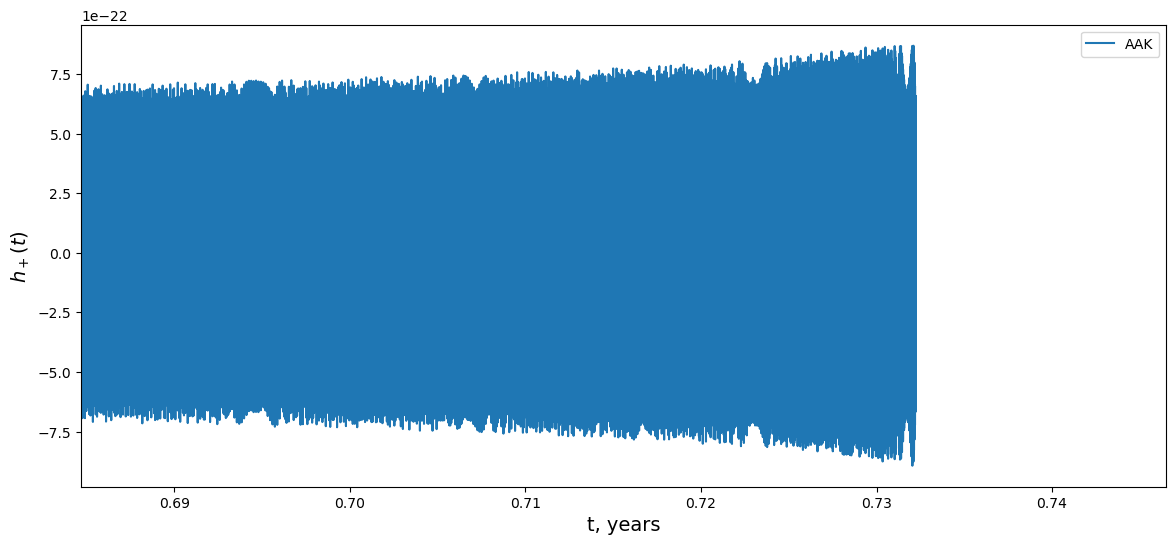

In [7]:
h_aak, t_merge_aak = emri_transform("AAK", 
    M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0, T, dt)

In [31]:
%%timeit
h_aak, t_merge_aak = emri_transform("AAK", 
    M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0, T, dt, False)

8.98 s ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Computing response via LDC Toolbox

In [8]:
import h5py
import logging

from ldc.waveform.waveform import HpHc, NumericHpHc
orbit_file = 'equalarmlength-orbits.h5'

In [9]:
from ldc.lisa.orbits import Orbits, OrbitsFromFile
from ldc.lisa.projection import ProjectedStrain

with h5py.File(orbit_file) as f:
    orbit_t0 = f.attrs['t0']
    L = f.attrs['L']

orbits = OrbitsFromFile({
  'orbit_type': 'file',
  'filename': orbit_file, 
  'nominal_arm_length': L},
  read_t0=False,
)

In [10]:
t_min = 0
t_max = t_merge_aak + 1000
t = np.arange(t_min, t_max, dt)

In [11]:
h_aak = np.concatenate([h_aak, np.zeros(t.size - h_aak.size)])

In [12]:
hphc_num = NumericHpHc(t, h_aak.real, h_aak.imag, qS, phiS)

In [13]:
projected_strain = ProjectedStrain(orbits)    
gw_response = projected_strain.arm_response(t_min + 500, t_max - 500, dt, [hphc_num])

In [32]:
%%timeit
hphc_num = NumericHpHc(t, h_aak.real, h_aak.imag, qS, phiS)
projected_strain = ProjectedStrain(orbits)    
gw_response = projected_strain.arm_response(t_min+500, t_max-500, dt, [hphc_num]) # ??

8.93 s ± 278 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


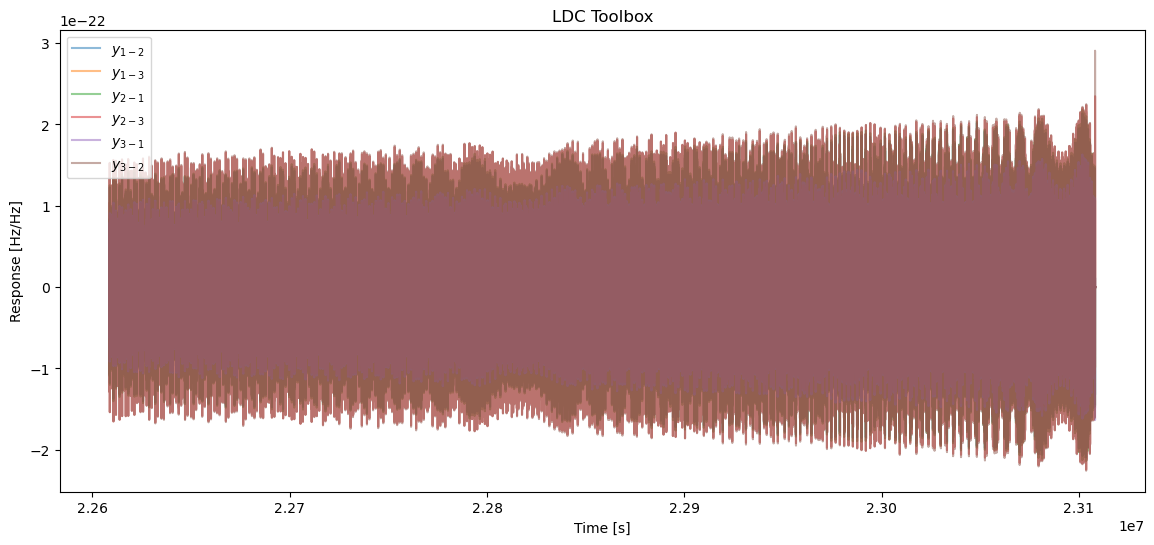

In [14]:
links = projected_strain.dlink
plt.figure(figsize=(14, 6))

for i, mosa in enumerate(links):
    plt.plot(t[-100000:], gw_response[-100000:, i], alpha=0.5, label=f'$y_{{{mosa}}}$')

plt.xlabel('Time [s]')
plt.ylabel('Response [Hz/Hz]')
plt.title('LDC Toolbox')
plt.legend();

# Computing TDI via LDC Toolbox

In [33]:
%%timeit
X_ldc = projected_strain.compute_tdi_x(t)
Y_ldc = projected_strain.compute_tdi_y(t)
Z_ldc = projected_strain.compute_tdi_z(t)

18.6 s ± 241 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
X_ldc = projected_strain.compute_tdi_x(t)
Y_ldc = projected_strain.compute_tdi_y(t)
Z_ldc = projected_strain.compute_tdi_z(t)

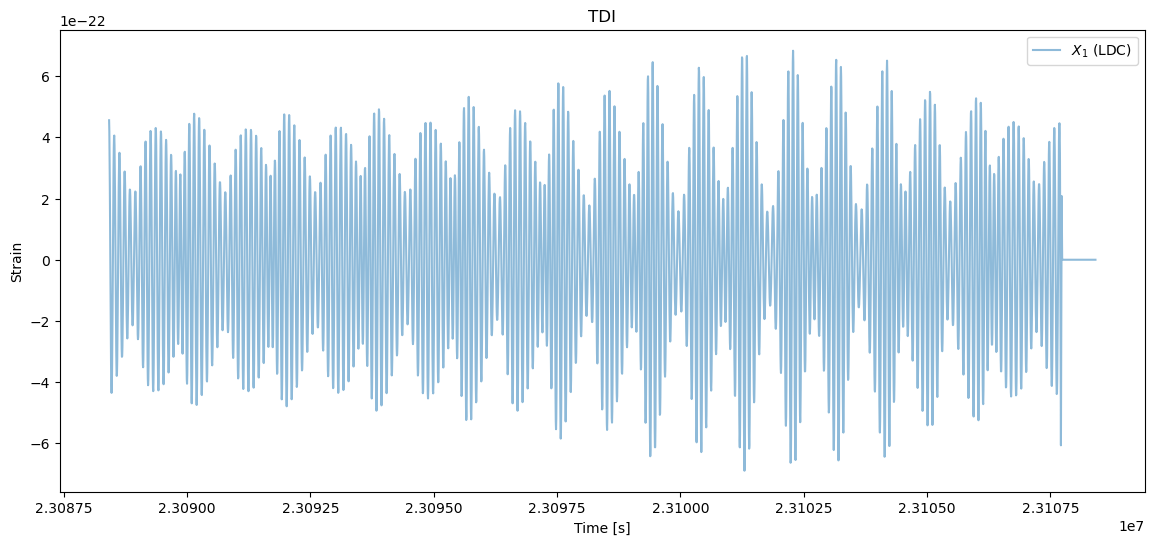

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(t[-4000:], X_ldc[-4000:], alpha=0.5, label=f'$X_1$ (LDC)')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.title('TDI')
plt.legend()

# Applying window function

In [17]:
from ldc.common.tools import window
window_function = window(t)

In [18]:
X_ldc_window = X_ldc * window_function
Y_ldc_window = Y_ldc * window_function
Z_ldc_window = Z_ldc * window_function

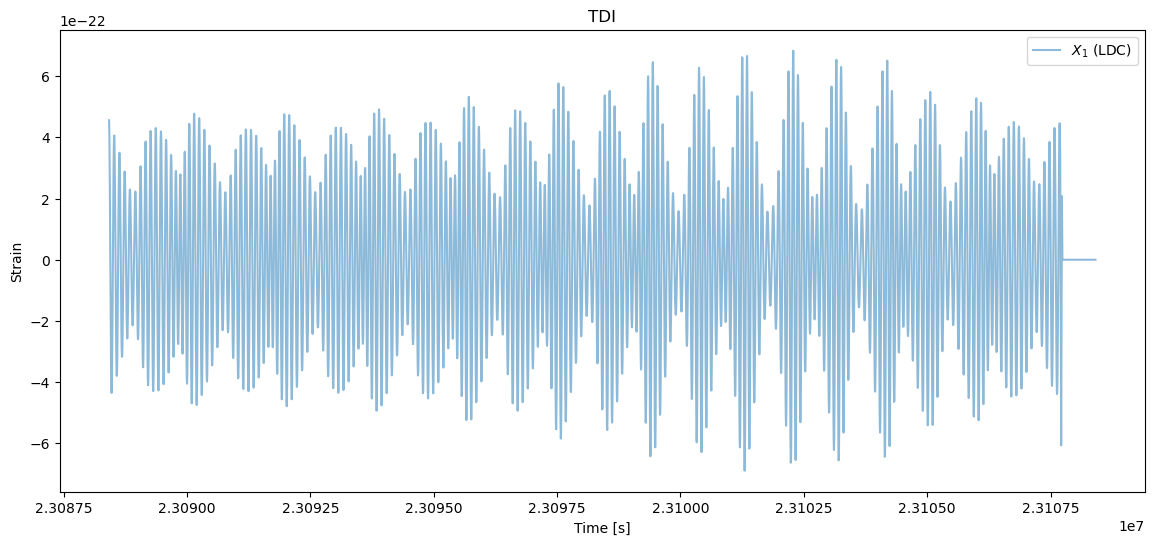

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(t[-4000:-1], X_ldc[-4000:-1], alpha=0.5, label=f'$X_1$ (LDC)')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.title('TDI')
plt.legend()

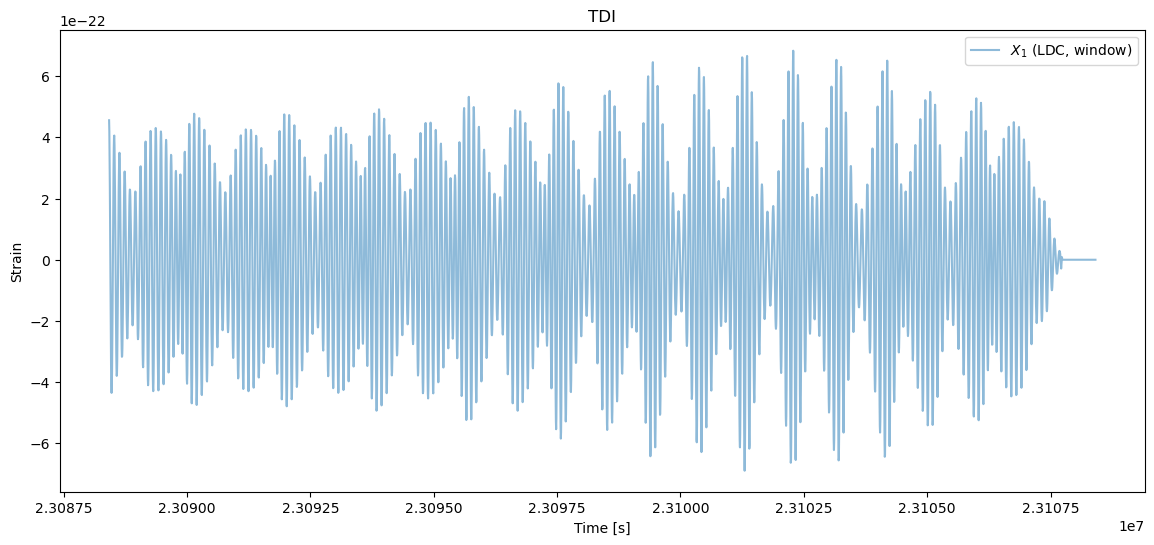

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(t[-4000:-1], X_ldc_window[-4000:-1], alpha=0.5, label=f'$X_1$ (LDC, window)')
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.title('TDI')
plt.legend()

All transform from parameteres to TDI takes about 30 seconds

# SNR and Likelihood function

In [21]:
from ldc.common.series import TimeSeries, FrequencySeries, TDI, XYZ2AET
from ldc.lisa.noise import get_noise_model
import scipy

In [22]:
def inner_product(lhsA, lhsE, rhsA, rhsE, SA, df):
    return 4.0*df*np.sum(np.real(lhsA * np.conj(rhsA) + lhsE * np.conj(rhsE))/SA)
    
def fourier(data, dt):
    '''
    params: data - list like with elements - arrays-like of equal size
    return: list - fourier transforms, frequences
    '''
    n = data[0].size
    for i in range(len(data)):
        data[i] = np.fft.rfft(data[i])[1:]
    
    freq = np.fft.rfftfreq(n, d=dt)[1:] # cause we want freq[0] != 0
    return data, freq


def crop_data(data, freq, fmin, fmax):
    '''
    params: data - list like with elements - arrays-like of equal size; freq - array-like of original frequencies;
    return: list - cropped data, cropped frequences
    '''
    if fmin == 0 and fmax == np.inf:
        return data, freq
    
    n = freq.size
    imin, imax = 0, n-1
    for i in range(n):
        if freq[i] > fmin:
            imin = i
            break
    for i in range(n-1, -1, -1):
        if freq[i] < fmax:
            imax = i
            break
    for i in range(len(data)):
        data[i] = data[i][imin:imax]
    freq = freq[imin:imax]
    return data, freq
    
def likelihood(dA, dE, hA, hE, dt, fmin = 0, fmax = np.inf, full = False):
    '''
    params: dA, dE, hA, hE in time domain with equal shapes
    dt - signal's dt
    return: float - likelihood
    '''
    data, freq = fourier([dA, dE, hA, hE], dt)
    [dAf, dEf, hAf, hEf], freq = crop_data(data, freq, fmin, fmax)
    
    df = freq[1] - freq[0]
    
    noise = get_noise_model("SciRDv1", freq, wd=1)
    SA = noise.psd(freq)
    result = inner_product(dAf, dEf, hAf, hEf, SA, df) - 0.5 * inner_product(hAf, hEf, hAf, hEf, SA, df)
    
    if full:
        result += - 0.5 * inner_product(dAf, dEf, dAf, dEf, SA, df)
    return result


In [42]:
def SNR(x, y, z, dt):
    A, E, _ = XYZ2AET(x, y, z)
    
    [Af, Ef], freq = fourier([A, E], dt)
    
    [Af, Ef], freq = crop_data([Af, Ef], freq, 6e-4, 2e-2)
    df = freq[1]-freq[0]
    noise = get_noise_model("SciRDv1", freq, wd=1)
    SA = noise.psd(freq)
    SN2 = 4.0*df*np.sum((np.abs(Af)**2 + np.abs(Ef)**2)/SA)
    plot_freq([Af, SA], freq, "TDI A")

    return (np.sqrt(SN2))

def plot_freq(data, freq, ylabel):
    plt.figure(figsize=(12, 6))
    plt.loglog(freq, np.abs(data[0]), label="signal")
    plt.loglog(freq, np.sqrt(data[1]), label="noise")
    plt.ylabel(ylabel)
    plt.xlabel("freq. [Hz]")
    plt.grid()
    plt.legend()

def cumulative_SNR_plot(x, y, z, dt):
    A, E, _ = XYZ2AET(x, y, z)
    
    [Af, Ef], freq = fourier([A, E], dt)
    df = freq[1]-freq[0]
    noise = get_noise_model("SciRDv1", freq, wd=1)
    SA = noise.psd(freq)
    SN2 = 4.0*df*np.cumsum((np.abs(Af)**2 + np.abs(Ef)**2)/SA)
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.log10(freq), np.sqrt(SN2))
    plt.xlabel("log10(freq)")
    plt.ylabel("SNR")
    plt.xlim([-4, -1])
    plt.grid()

In [43]:
plt.rcParams.update({'font.size': 18})

31.634592665508613

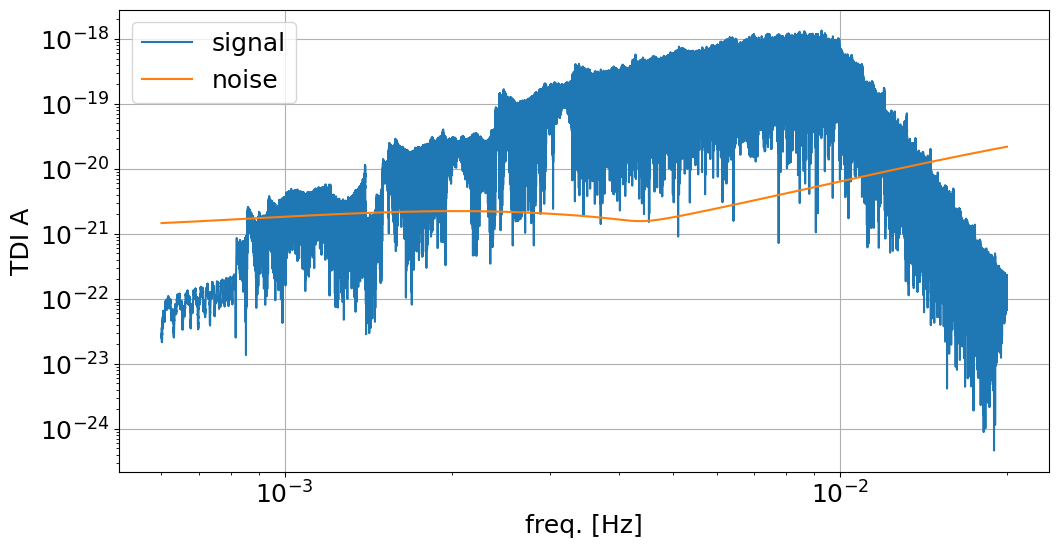

In [44]:
SNR(X_ldc_window, Y_ldc_window, Z_ldc_window, dt)

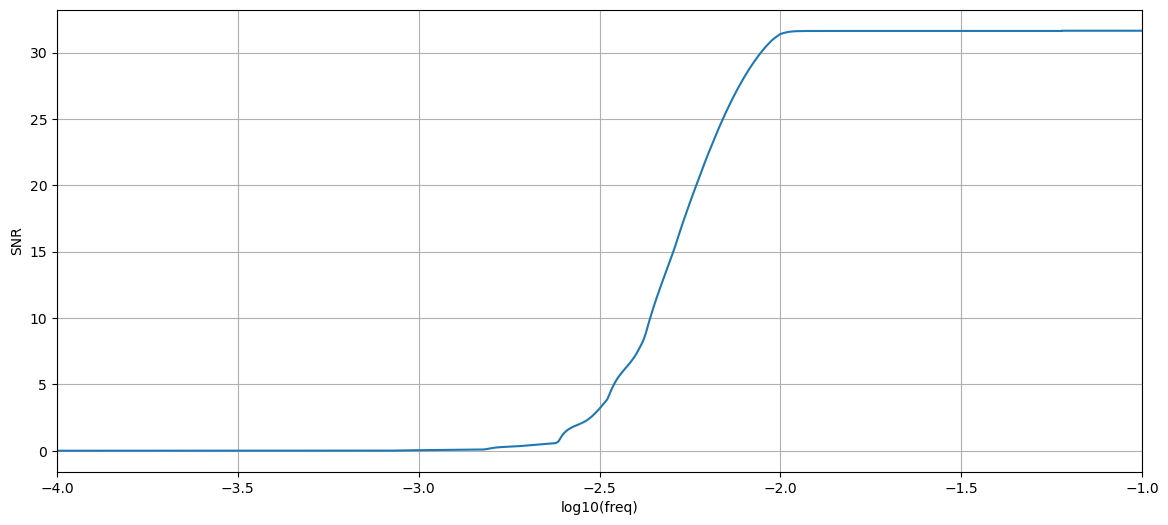

In [23]:
cumulative_SNR_plot(X_ldc_window, Y_ldc_window, Z_ldc_window, dt)

In [24]:
A, E, _ = XYZ2AET(X_ldc_window, Y_ldc_window, Z_ldc_window)

In [25]:
likelihood(A, E, A, E, dt)

500.8969258169782

500.37372728347606

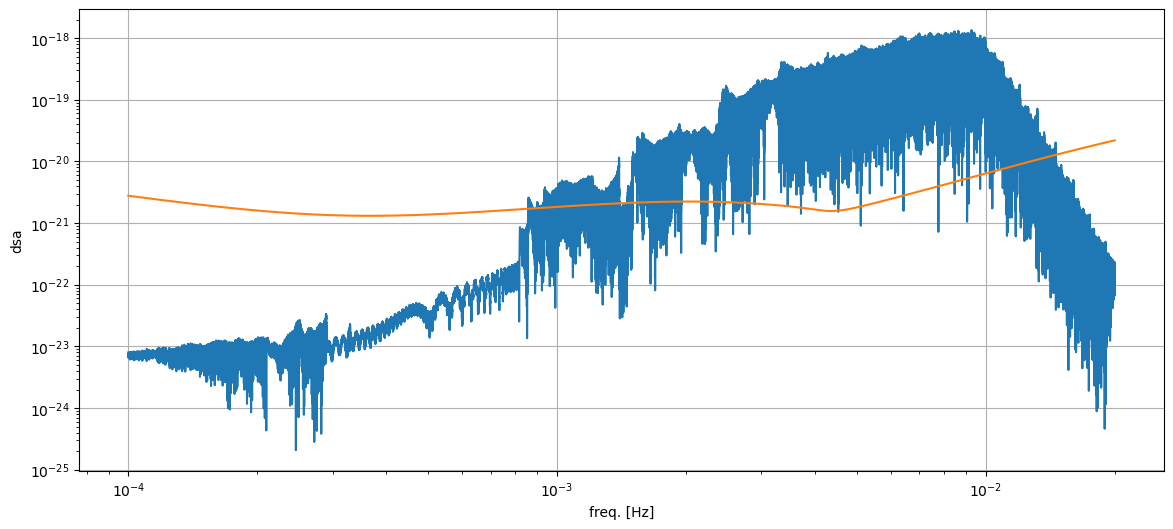

In [26]:
SNR(X_ldc_window, Y_ldc_window, Z_ldc_window, dt) ** 2 / 2

In [34]:
%%timeit
likelihood(A, E, A, E, dt)

6.31 s ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit
likelihood(A, E, A, E, dt, 8e-4, 1.5e-2)

6.02 s ± 9.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%%timeit
SNR(X_ldc, Y_ldc, Z_ldc, dt) ** 2 / 2

4.07 s ± 69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
[Af, Ef], freq = fourier([A, E], dt)
noise = get_noise_model("SciRDv1", freq, wd=1)
SA = noise.psd(freq)
df = freq[1] - freq[0]

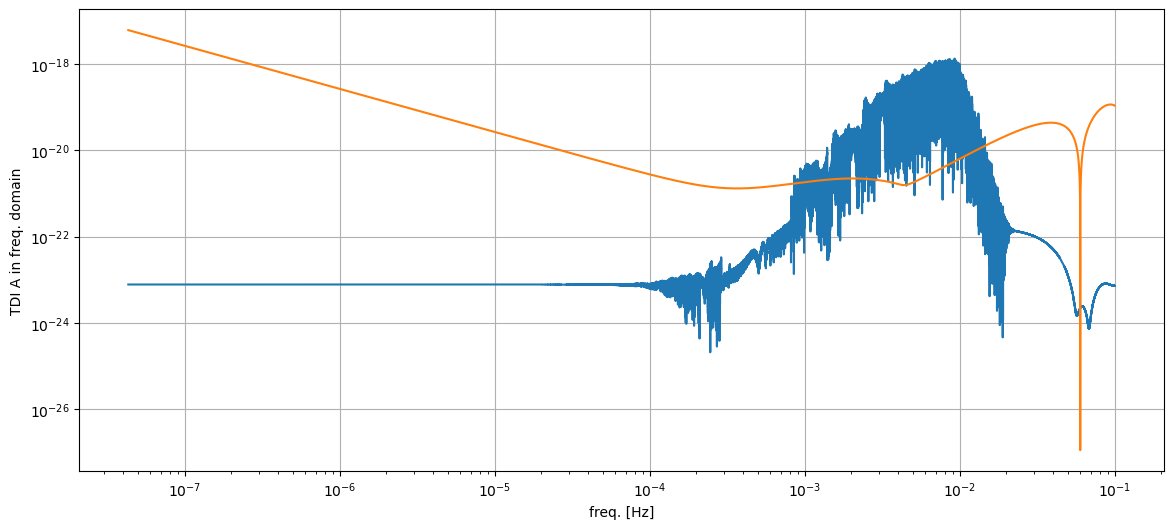

In [31]:
plot_freq([Af, SA], freq, "TDI A in freq. domain")

In [32]:
[Af, Ef], freq = crop_data([Af, Ef], freq, 2e-4, 2e-2)
SA = noise.psd(freq)

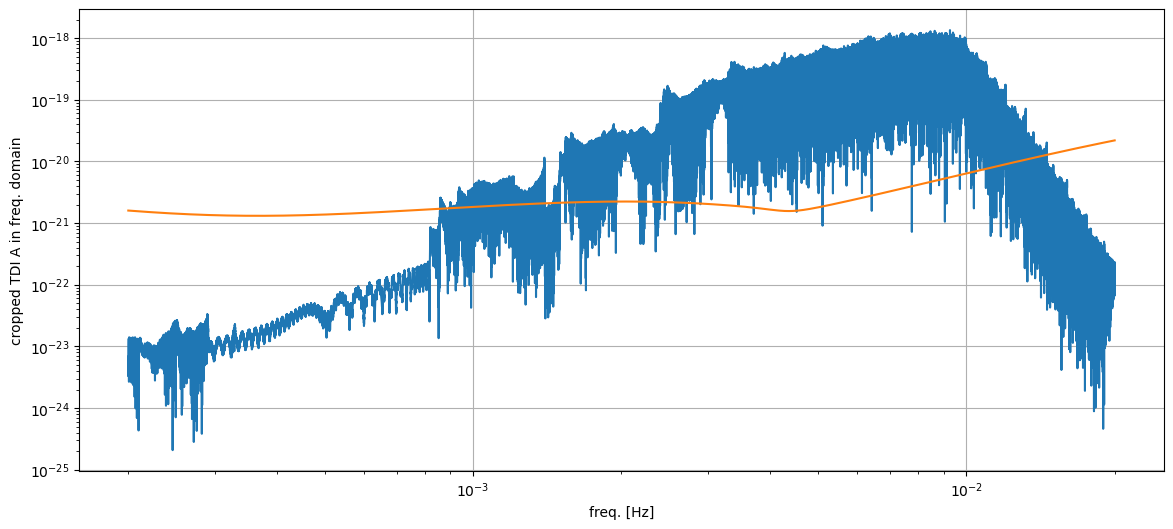

In [33]:
plot_freq([Af, SA], freq, "cropped TDI A in freq. domain")

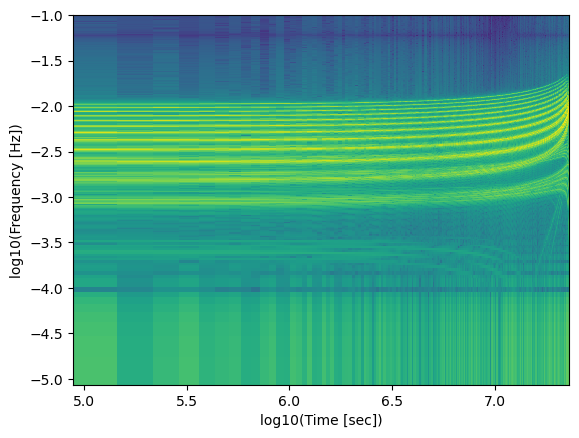

In [28]:
f, t, Sxx = scipy.signal.spectrogram(X_ldc_window, 1/dt, nperseg=2**14)
f = f[1:]
t = t[1:]
Sxx = Sxx[1:,1:]
plt.pcolormesh(np.log10(t), np.log10(f), np.log10(Sxx))

plt.ylabel('log10(Frequency [Hz])')

plt.xlabel('log10(Time [sec])')

plt.show()